# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Spaceship Titanic 데이터를 활용한 탑승유무 분류모형 개발
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 강사명 : 정지훈 강사
- 수강생명 : 조해성

In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# step 1. 라이브러리 및 데이터 불러오기
- 라이브러리를 불러온다.

In [2]:
# preprocessing
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)

1.20.3
1.3.5


In [3]:
# visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
# Missing Value processing
from sklearn.impute import SimpleImputer

In [5]:
# Encoding
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [6]:
# Split
from sklearn.model_selection import train_test_split

In [7]:
# Models
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [8]:
# Cross
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
import time

## 데이터 불러오기
- 훈련 데이터는 8,693개, 테스트 데이터는 4,277개.

In [9]:
train_data = pd.read_csv("../input/spaceship-titanic/train.csv")
test_data = pd.read_csv("../input/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")



print(train_data.shape)
print(test_data.shape)
print(sample_submission.shape)

(8693, 14)
(4277, 13)
(4277, 2)


## Column 설명
- PassengerId는 "AAAA_BB"형태이다. AAAA는 그룹을 나타내고, BB는 그룹안에서의 개개인을 지칭한다.
- HomePlanet은 고향별을 나타낸다.
- CryoSleep은 여행중에 냉동수면 여부를 나타낸다.
- cabin은 승객이 머무르는 공간을 나타낸다. deck/number/side 형태로 구성된다. side의 P는 Port를 나타내고, S는 Starboard를 나타낸다.
- Age는 승객의 나이이다.
- VIP는 승객이 special VIP service 비용을 지불했는지를 보여준다.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck는 각각 우주선의 편의시설에 승객이 비용을 지불했는지를 나타낸다.
- Name은 승객의 이름으로, first name, last name 순이다.
- Transported 칼럼이 타깃 데이터이다. 승객이 다른 차원으로 운송되었는지 여부를 보여준다. 훈련 데이터에는 Transported 칼럼이 있고, 테스트 데이터에는 Transported 칼럼이 있다. Transported 칼럼을 예측해야 할 것이다.

## train data
- 훈련 데이터를 살펴본다.
- 훈련 데이터에는 14개의 열이 있고, 8,693개의 행(샘플)이 있다.
- 훈련 데이터에는 119,378개의 특성이 있다.
- 훈련 데이터안에는 2,324개의 결측치가 있다.
- Transported 열은 훈련 데이터 안에서만 사용할 수 있다.
- 14개의 열 중에서 CryoSleep 열 안에 217개로 가장 많은 결측치가 있다. 

In [10]:
# first 5 rows of train dataset
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [12]:

print(f'\033[94mNumber of rows in train data: {train_data.shape[0]}')
print(f'\033[95mNumber of columns in train data: {train_data.shape[1]}')
print(f'\033[92mNumber of vlaues in train data: {train_data.count().sum()}')
print(f'\033[93mNumber of with missing values in train date: {sum(train_data.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of vlaues in train data: 119378
Number of with missing values in train date: 2324


In [13]:
print(train_data.isna().sum().sort_values(ascending = False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


- 갯수, 평균, 표준편차, 최솟값, 최댓값, 4분위수 등의 기초 통계량을 확인한다.

In [14]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## test data
- 테스트 데이터에는 13개의 열이 있고, 4,277개의 행(샘플)이 있다.
- 테스트 데이터에는 54,484개의 특성이 있다.
- 훈련 데이터안에는 1,117개의 결측치가 있다.
- 13개의 열 중에서 FoodCourt 열 안에 217개로 가장 많은 결측치가 있다.
- 종속변수는 Transported임을 알 수 있다.

In [15]:
# first 5 rows of test data 
test_data.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [16]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [17]:
print(f'\033[94mNumber of rows in test data: {test_data.shape[0]}')
print(f'\033[95mNumber of columns in test data: {test_data.shape[1]}')
print(f'\033[92mNumber of vlaues in test data: {test_data.count().sum()}')
print(f'\033[93mNumber of rows with missing values in test date: {sum(test_data.isna().sum())}')

Number of rows in test data: 4277
Number of columns in test data: 13
Number of vlaues in test data: 54484
Number of rows with missing values in test date: 1117


In [18]:
print((test_data.isna().sum().sort_values(ascending = False)))

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


- 갯수, 평균, 표준편차, 최솟값, 최댓값, 4분위수 등의 기초 통계량을 확인한다.

In [19]:
test_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


### Sample_Submission File
- 식별할 수 있는 PassengerId 열과 종속변수인 Transported 열로 구성되어있다.

In [20]:
# first 5 rows of submission file
sample_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [21]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


# Step 2. 탐색적 자료 분석(EDA)

## 데이터 시각화를 위한 주요 함수
- 우선 종속변수의 갯수에 대해 확인한다.
- boolean값이 비슷하게 분포 되어 있다.

In [22]:
train_data['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [23]:
train_data['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

- 시각화를 위한 함수를 정의한다.

In [24]:
def cnt_bar(data, col_name):
    df = data[col_name].value_counts()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = [str(item) for item in list(data[col_name].value_counts().index)]
    bars = sns.countplot(x=col_name, data=data, color='lightgray', alpha=0.9, zorder=2, ax=ax)
    
    for bar in bars.patches:
        fontweight = "normal"
        color = "k"
        height = np.round(bar.get_height(), 2)
        if bar.get_height() == data[col_name].value_counts().values[0]:
            fontweight="bold"
            color="hotpink"
            bar.set_facecolor(color)
        ax.text(bar.get_x() + bar.get_width()/2., height+100, height+1, ha = 'center', size=12, fontweight=fontweight, color=color)
    ax.set_title(f'Bar Graph of {col_name}', size = 20)
    ax.set_xlabel(col_name, size = 20)
    ax.set_ylabel("No. Passengers", size = 20)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(("outward", 20))
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(axis="y", which="major", color="lightgray")
    ax.grid(axis="y", which="minor", ls=":")
    
    plt.show()

- 함수를 적용해본다.
    - Cabin, PassengerId 열은 적용할 수 없다.

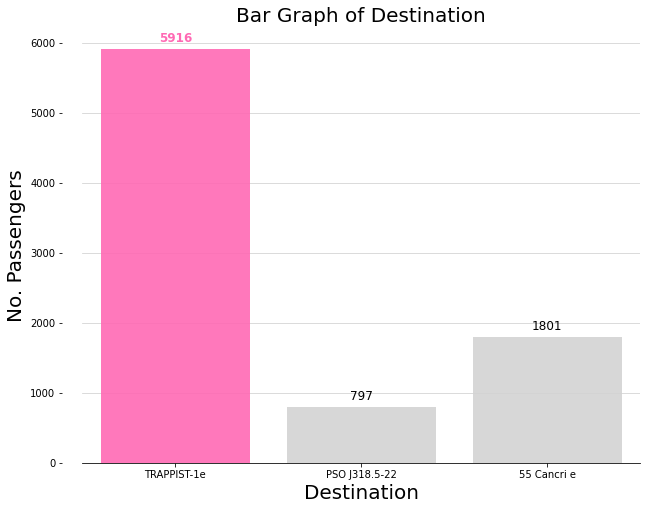

In [25]:
cnt_bar(train_data, "Destination")

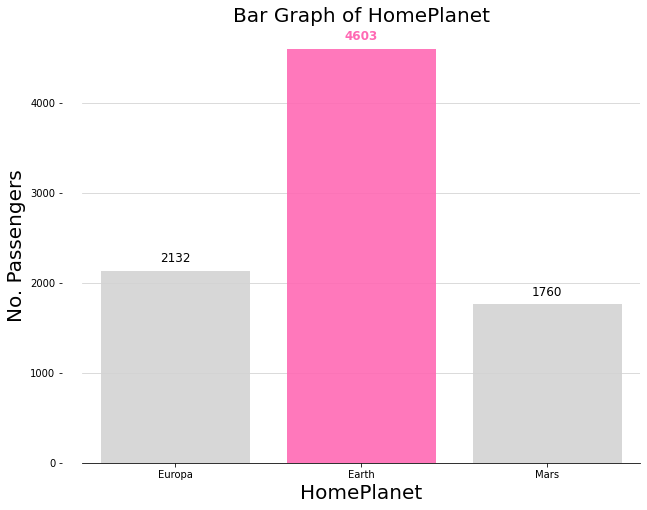

In [26]:
cnt_bar(train_data, "HomePlanet")

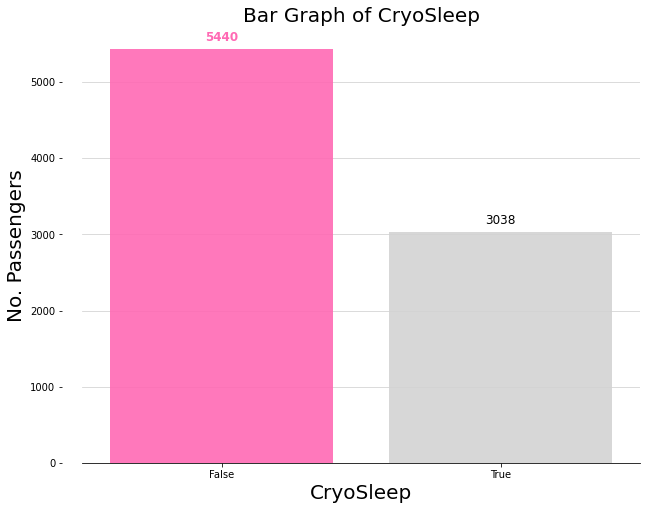

In [27]:
cnt_bar(train_data, "CryoSleep")

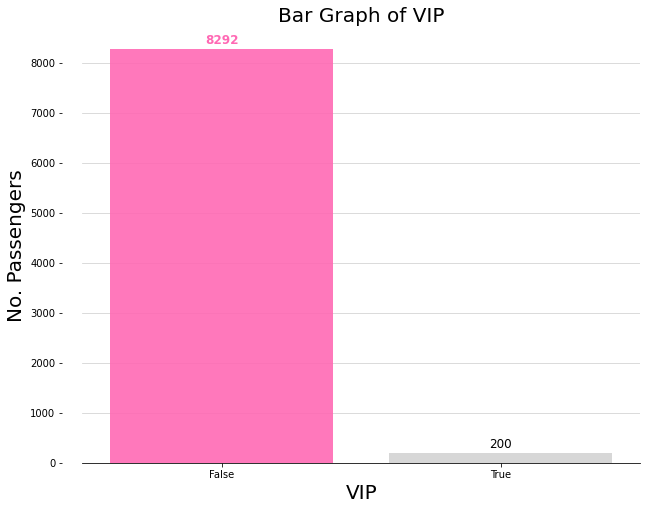

In [28]:
cnt_bar(train_data, "VIP")

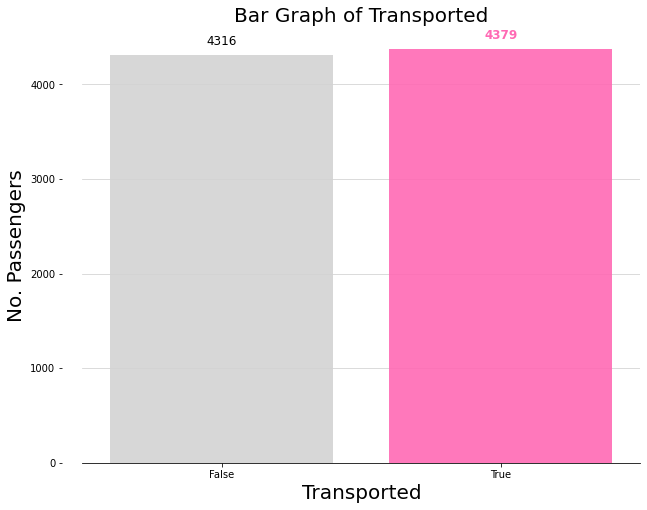

In [29]:
cnt_bar(train_data, "Transported")

- RoomService, FoodCourt, Spa는 연속형 데이터가 아니라 비연속형 데이터임을 확인한다.

In [30]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [31]:
numeric_features = train_data.select_dtypes(include=[np.number])
numeric_features.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

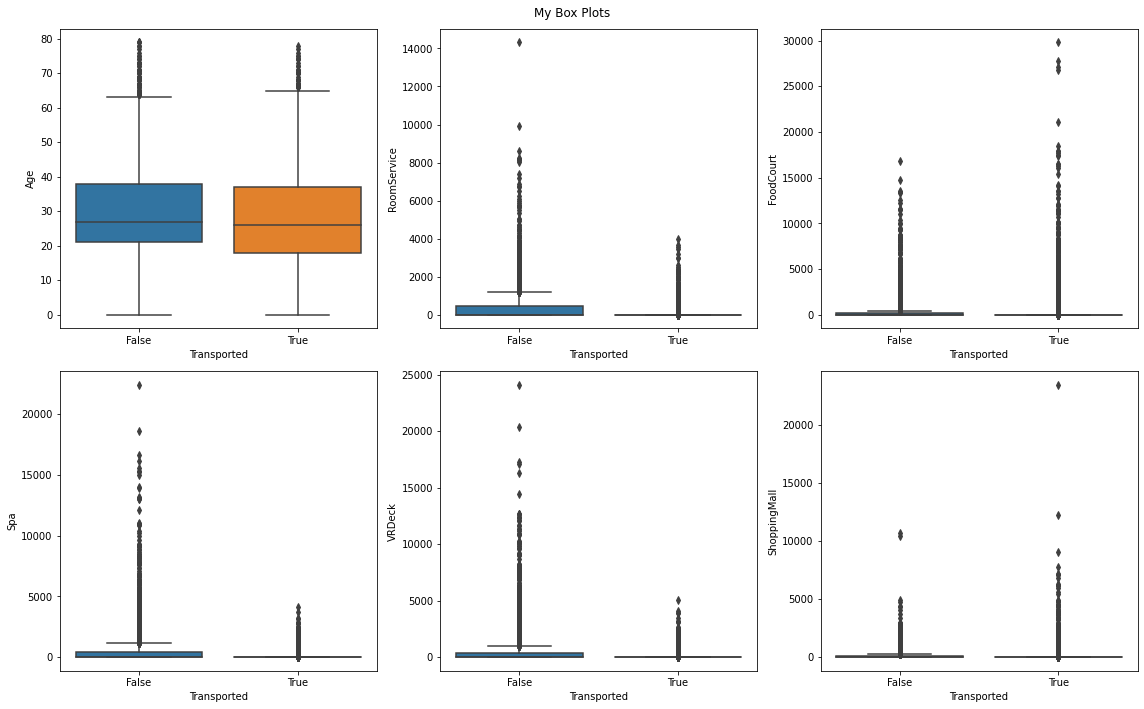

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10)) # 그래프의 행과 열 지정 및, 이미지 사이즈 지정
data = train_data.copy()
# data[numeric_features.columns].columns[0:]
for i, col in enumerate(data[numeric_features.columns].columns[0:]): # 좌표 평면 지정
    # print(i, col)
    if i <= 2:
        sns.boxplot(x=data["Transported"], y=data[col], ax=ax[0,i]) # 1행 좌표 평면
    else: 
        sns.boxplot(x=data["Transported"], y=data[col], ax=ax[1,i-4]) # 5행 좌표 평면
fig.suptitle('My Box Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [33]:
train_data['RoomService'].value_counts()

0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: RoomService, Length: 1273, dtype: int64

In [34]:
train_data['FoodCourt'].value_counts()

0.0       5456
1.0        116
2.0         75
3.0         53
4.0         53
          ... 
3846.0       1
5193.0       1
312.0        1
827.0        1
4688.0       1
Name: FoodCourt, Length: 1507, dtype: int64

In [35]:
train_data['Spa'].value_counts()

0.0       5324
1.0        146
2.0        105
5.0         53
3.0         53
          ... 
273.0        1
2581.0       1
2948.0       1
3778.0       1
1643.0       1
Name: Spa, Length: 1327, dtype: int64

# Step 3. 데이터 전처리


## 불필요한 변수 제거

- PassengerId, Name, Cabin 열은 쓰지 않는다.
- 따라서, 제거한다.

In [36]:
train_data['Name'].value_counts()

Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: Name, Length: 8473, dtype: int64

In [37]:
train_data['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [38]:
remove_cols = ['PassengerId', 'Name', 'Cabin']
passenferId = test_data['PassengerId']

print("Before:", train_data.shape, test_data.shape)
train_data = train_data.drop(remove_cols, axis = 1)
test_data = test_data.drop(remove_cols, axis= 1)

print("After:", train_data.shape, test_data.shape)

Before: (8693, 14) (4277, 13)
After: (8693, 11) (4277, 10)


## 결측치
- 결측치 데이터를 확인한다.
- 결측치 데이터를 채워 넣는다.
- 우선, 수치형 데이터부터 해준다.

In [39]:
train_data.isnull().sum().sort_values(ascending = False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [40]:
test_data.isnull().sum().sort_values(ascending = False)

FoodCourt       106
Spa             101
ShoppingMall     98
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
dtype: int64

In [41]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
STRATEGY = 'median'

imputer = SimpleImputer(strategy=STRATEGY)
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

print("train:\n", train_data.isnull().sum())
print("----------------")
print("test:\n", test_data.isnull().sum())

train:
 HomePlanet      201
CryoSleep       217
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64
----------------
test:
 HomePlanet      87
CryoSleep       93
Destination     92
Age              0
VIP             93
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
dtype: int64


- 문자열 데이터를 처리한다.

In [42]:
imputer_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
STRATEGY = 'most_frequent'

imputer = SimpleImputer(strategy=STRATEGY)
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

print("train:\n", train_data.isnull().sum())
print("---")
print("test:\n", test_data.isnull().sum())

train:
 HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64
---
test:
 HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


## Categorical Feature Encoding
- 문자열의 경우 수치형으로 변환해주어야 한다.
- OneHot Encoding 방식

### Onehot Encoding


In [43]:
train_data['Transported'] = train_data['Transported'].map({True: 1, False: 0})
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

transformer = make_column_transformer(
    (OneHotEncoder(), categorical_cols),
    remainder='passthrough')

train_transformed = transformer.fit_transform(train_data[categorical_cols])
train_transformed_df = pd.DataFrame(train_transformed, columns=transformer.get_feature_names_out())
train_data = pd.concat([train_data, train_transformed_df], axis = 1)
train_data = train_data.drop(categorical_cols, axis = 1)

test_transformed = transformer.fit_transform(test_data[categorical_cols])
test_transformed_df = pd.DataFrame(test_transformed, columns=transformer.get_feature_names_out())
test_data = pd.concat([test_data, test_transformed_df], axis = 1)
test_data = test_data.drop(categorical_cols, axis = 1)

- 종속변수를 제외한 모든 열이 실수형이 된 것을 확인한다.

In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       8693 non-null   float64
 1   RoomService                               8693 non-null   float64
 2   FoodCourt                                 8693 non-null   float64
 3   ShoppingMall                              8693 non-null   float64
 4   Spa                                       8693 non-null   float64
 5   VRDeck                                    8693 non-null   float64
 6   Transported                               8693 non-null   int64  
 7   onehotencoder__HomePlanet_Earth           8693 non-null   float64
 8   onehotencoder__HomePlanet_Europa          8693 non-null   float64
 9   onehotencoder__HomePlanet_Mars            8693 non-null   float64
 10  onehotencoder__CryoSleep_False      

In [45]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       4277 non-null   float64
 1   RoomService                               4277 non-null   float64
 2   FoodCourt                                 4277 non-null   float64
 3   ShoppingMall                              4277 non-null   float64
 4   Spa                                       4277 non-null   float64
 5   VRDeck                                    4277 non-null   float64
 6   onehotencoder__HomePlanet_Earth           4277 non-null   float64
 7   onehotencoder__HomePlanet_Europa          4277 non-null   float64
 8   onehotencoder__HomePlanet_Mars            4277 non-null   float64
 9   onehotencoder__CryoSleep_False            4277 non-null   float64
 10  onehotencoder__CryoSleep_True       

# Step 4. 머신러닝 모형 개발


- 독립변수와 족송변수를 구분한다.

In [46]:
X_cols = test_data.columns
X = train_data[X_cols].to_numpy()
y = train_data['Transported'].to_numpy()

- 훈련 데이터에서 일부를 검증데이터로 떼어낸다. 

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6085, 16), (2608, 16), (6085,), (2608,))

- LightGBM 클래스를 임포트한다.

In [48]:
lgb = LGBMClassifier(random_state=42)
lgb

LGBMClassifier(random_state=42)

## Model Selection
- 그리드 서치를 적용한다.

- 모형을 정의한다.

In [49]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "LGBM" : LGBMClassifier(random_state=0)
}

- 그리드 서치를 위한 옵션을 선택한다.

In [50]:
# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "RandomForest" : RF_grid,
    "LGBM" : boosted_grid
}

- 모형과 그리드 서치를 정의한다.

In [51]:
# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
import time

i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_val, y_val)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model: LogisticRegression
Training time (mins): 0.07

Model: KNN
Training time (mins): 0.07

Model: RandomForest
Training time (mins): 0.74

Model: LGBM
Training time (mins): 0.22



- 4개의 모형에 대한 속도와 정확도 평가를 확인한다.

In [52]:
# Show results
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.778758,0.07
1,KNN,0.777991,0.07
2,RandomForest,0.790644,0.74
3,LGBM,0.792561,0.22


- 가장 좋은 파라미터를 찾는다.

In [53]:
clf_best_params

{'LogisticRegression': {'C': 1, 'max_iter': 150, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 2},
 'RandomForest': {'max_depth': 10, 'n_estimators': 50},
 'LGBM': {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50}}

In [54]:
# Classifiers
best_classifiers = {
    "RandomForest" : RandomForestClassifier(**clf_best_params["RandomForest"], random_state=0),
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0)
}

In [55]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(test_data))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 5-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(test_data)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has featu

Model: RandomForest
Average validation accuracy: 79.64
Training time (mins): 0.06

Model: LGBM
Average validation accuracy: 79.48
Training time (mins): 0.02



# Step 5. 모형 평가


In [56]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))

train Acc. 0.8584804195058158
test Acc. 0.7923066112123417


In [57]:
from sklearn.metrics import accuracy_score

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print("Acc.", accuracy_score(y_val, y_pred))

Acc. 0.8401073619631901


# Step 6. 제출


In [58]:
preds=np.round(preds).astype(bool)
sample_submission['Transported'] = preds
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# Reference
- Spaceship Titanic -EDA + 27 different models
- https://www.kaggle.com/code/odins0n/spaceship-titanic-eda-27-different-models

- Spaceship Titanic: A complete guide
- https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

